<a href="https://colab.research.google.com/github/isaacduong/pneumonia-dataset/blob/master/pneumonia_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization,MaxPool2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop, Adam
from sklearn.metrics import classification_report, confusion_matrix
import random
import cv2
from tensorflow.keras.utils import to_categorical

In [56]:
BASE_PATH = '/content/drive/My Drive/chest_xray/'

* File paths

In [57]:
train_normal = BASE_PATH + 'train/NORMAL/'
train_pneum = BASE_PATH + 'train/PNEUMONIA/'

test_normal = BASE_PATH + 'test/NORMAL/'
test_pneum = BASE_PATH + 'test/PNEUMONIA/'

val_normal = BASE_PATH + 'val/NORMAL/'
val_pneum = BASE_PATH + 'val/PNEUMONIA/'

In [58]:
train_normal_images = glob.glob(train_normal + '*jpeg')
train_pneum_images = glob.glob(train_pneum + '*jpeg')

test_normal_images = glob.glob(test_normal + '*jpeg')
test_pneum_images = glob.glob(test_pneum + '*jpeg')

val_normal_images = glob.glob(val_normal + '*jpeg')
val_pneum_images = glob.glob(val_pneum + '*jpeg')

In [66]:
train = []
test = []
val = []

# Appending Train Data
for x in train_normal_images:
    train.append([x, 0])
    
for x in train_pneum_images:
    train.append([x,1])
    
# Appending test Data
    
for x in test_normal_images:
    test.append([x,0])
    
for x in test_pneum_images:
    test.append([x,1])
    
# Appending val Data    
 
for x in val_normal_images:
    val.append([x,0])
    
for x in val_pneum_images:
   val.append([x,1])
    

In [67]:
val

[['/content/drive/My Drive/chest_xray/val/NORMAL/NORMAL2-IM-1430-0001.jpeg',
  0],
 ['/content/drive/My Drive/chest_xray/val/NORMAL/NORMAL2-IM-1436-0001.jpeg',
  0],
 ['/content/drive/My Drive/chest_xray/val/NORMAL/NORMAL2-IM-1437-0001.jpeg',
  0],
 ['/content/drive/My Drive/chest_xray/val/NORMAL/NORMAL2-IM-1438-0001.jpeg',
  0],
 ['/content/drive/My Drive/chest_xray/val/NORMAL/NORMAL2-IM-1442-0001.jpeg',
  0],
 ['/content/drive/My Drive/chest_xray/val/NORMAL/NORMAL2-IM-1427-0001.jpeg',
  0],
 ['/content/drive/My Drive/chest_xray/val/NORMAL/NORMAL2-IM-1440-0001.jpeg',
  0],
 ['/content/drive/My Drive/chest_xray/val/NORMAL/NORMAL2-IM-1431-0001.jpeg',
  0],
 ['/content/drive/My Drive/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg',
  1],
 ['/content/drive/My Drive/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg',
  1],
 ['/content/drive/My Drive/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg',
  1],
 ['/content/drive/My Drive/chest_xray/val/PNEUMONIA/person1946_bac

In [69]:
random.shuffle(train)

random.shuffle(test)

random.shuffle(val)

In [71]:
train = pd.DataFrame(train, columns = ['images', 'labels'])
test = pd.DataFrame(test, columns = ['images', 'labels'])
val = pd.DataFrame(val, columns = ['images', 'labels'])

In [72]:
train.head()

,images,labels
0,/content/drive/My Drive/chest_xray/train/PNEUM...,1
1,/content/drive/My Drive/chest_xray/train/NORMA...,0
2,/content/drive/My Drive/chest_xray/train/PNEUM...,1
3,/content/drive/My Drive/chest_xray/train/PNEUM...,1
4,/content/drive/My Drive/chest_xray/train/PNEUM...,1


In [73]:
test.head()

,images,labels
0,/content/drive/My Drive/chest_xray/test/NORMAL...,0
1,/content/drive/My Drive/chest_xray/test/PNEUMO...,1
2,/content/drive/My Drive/chest_xray/test/NORMAL...,0
3,/content/drive/My Drive/chest_xray/test/NORMAL...,0
4,/content/drive/My Drive/chest_xray/test/PNEUMO...,1


* Data Exploration

In [74]:
train['labels'].value_counts()

1    3875
0    1341
Name: labels, dtype: int64

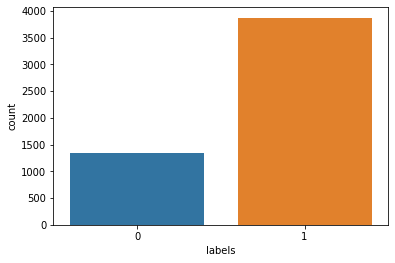

In [80]:
sns.countplot(train.labels)

In [81]:
test['labels'].value_counts()

1    390
0    234
Name: labels, dtype: int64

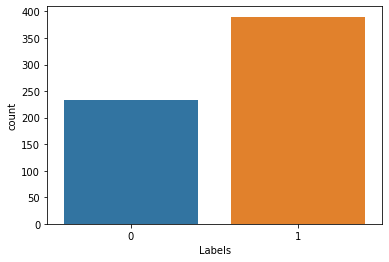

In [15]:
sns.countplot(test.labels);

In [85]:
val['labels'].value_counts()

1    8
0    8
Name: labels, dtype: int64

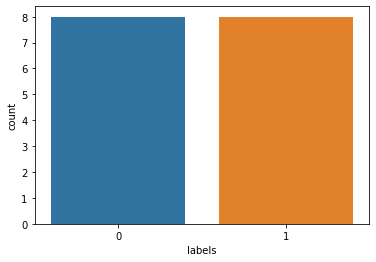

In [86]:
sns.countplot(val.labels);

# Visualizations
* Plotting some healthy and non healthy images

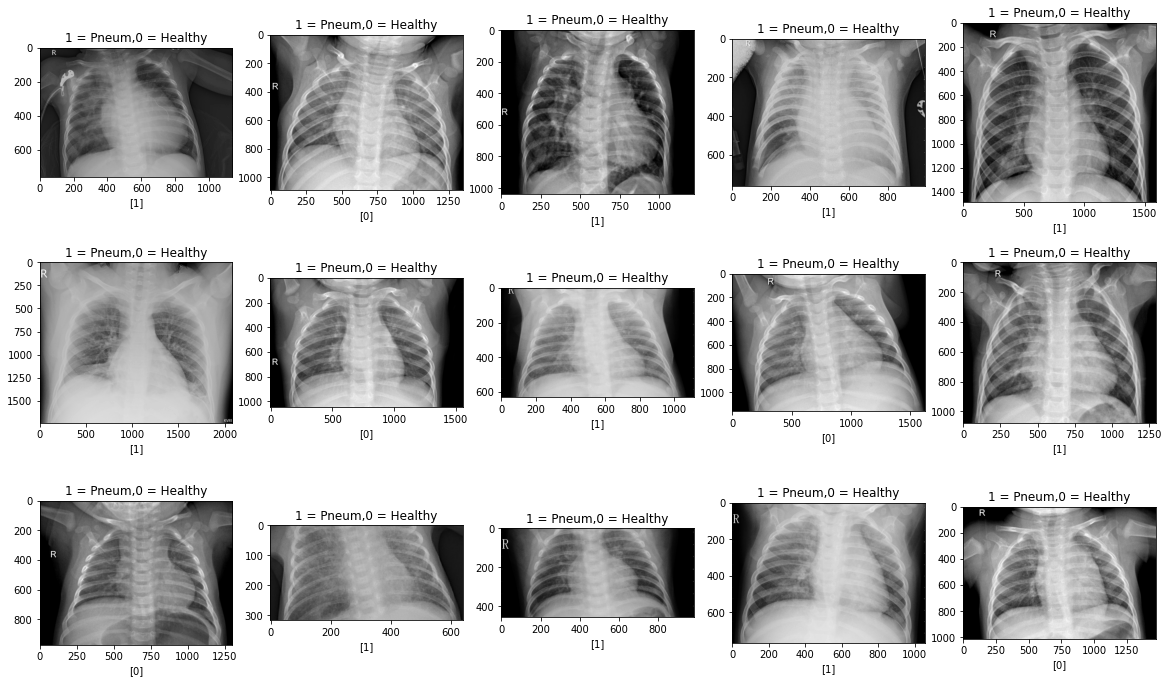

In [87]:
plt.figure(figsize=(20,12))
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.grid(False)
    img = plt.imread(train['images'][i])
    plt.imshow(img, cmap='gray')
    plt.title('1 = Pneum,0 = Healthy')
    plt.xlabel([train['labels'][i]])
plt.show()

* Data preprocessing
* Building a fuction to preprocess the images

In [88]:
def process_data(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0 
    img = np.reshape(img, (224,224,1))
    
    return img

In [89]:
def compose_dataset(df):
    data = []
    labels = []

    for img_path, label in df.values:
        data.append(process_data(img_path))
        labels.append(label)
        
    return np.array(data), np.array(labels)


In [20]:
x_train, y_train = compose_dataset(train)
x_test, y_test = compose_dataset(test)
x_val, y_val = compose_dataset(val)

In [21]:
print(x_train.shape,y_train.shape)
print(x_test.shape, y_test.shape)
print(x_val.shape, y_val.shape)

(5216, 224, 224, 1) (5216,)
(624, 224, 224, 1) (624,)
(16, 224, 224, 1) (16,)


In [22]:
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range = 0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
)
datagen.fit(x_train)

# Building Cnn Model

In [23]:
model = Sequential()
model.add(Conv2D(filters=8, kernel_size=(7,7), padding='same', activation='relu', input_shape=(224, 224, 1)))
model.add(Conv2D(filters=8, kernel_size=(7,7), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Conv2D(filters=16, kernel_size=(5,5), padding='same', activation='relu'))
model.add(Conv2D(filters=16, kernel_size=(5,5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 8)       400       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 8)       3144      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 74, 74, 16)        3216      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 74, 74, 16)        6416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 32)        4

* Compiling the model

In [25]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

* Training the model On training set 

In [27]:
history = model.fit(datagen.flow(x_train,y_train, batch_size=32),
                    validation_data=(x_test, y_test),
                    epochs = 1)

163/163 [==============================] - 771s 5s/step - loss: 0.2361 - accuracy: 0.9022 - val_loss: 0.3607 - val_accuracy: 0.8446


* Prediction on test set

In [28]:
model.evaluate(x_test,y_test)

20/20 [==============================] - 19s 960ms/step - loss: 0.3607 - accuracy: 0.8446


[0.3606593608856201, 0.8445512652397156]

In [32]:
preds = model.predict_classes(x_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [33]:
preds = np.array(preds)
preds[:10]

array([[0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]], dtype=int32)

* Classification report

In [34]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.88      0.68      0.77       234
           1       0.83      0.95      0.88       390

    accuracy                           0.84       624
   macro avg       0.86      0.81      0.82       624
weighted avg       0.85      0.84      0.84       624

